In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from wordcloud import WordCloud
from collections import Counter

In [42]:
#Loading data
dataPath="C:/Users/USER/Desktop/ML Materials/CognoRise Internship/TAsk One_Spam/Resources/spam.csv"
data= pd.read_csv(dataPath)

In [5]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Data cleaning
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [43]:
# Encoding the Category
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [44]:
# Checking for null values and duplicates
data.isnull().sum()
data.drop_duplicates(inplace=True)

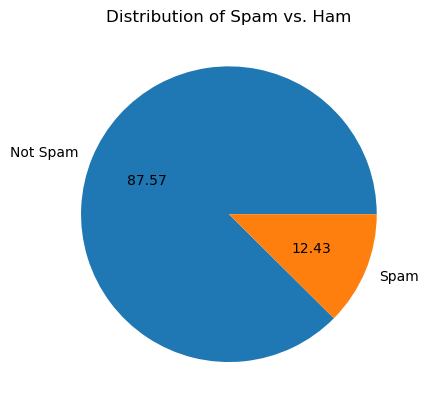

In [45]:
# Data Visualization
plt.pie(data['Category'].value_counts(), labels=['Not Spam', 'Spam'], autopct='%0.2f')
plt.title('Distribution of Spam vs. Ham')
plt.show()

In [46]:
# Counting characters, words, and sentences
data['Num_Chars'] = data['Message'].apply(len)
data['Num_words'] = data['Message'].apply(lambda x: len(word_tokenize(x)))
data['Num_Sent'] = data['Message'].apply(lambda x: len(sent_tokenize(x)))

In [47]:
# Descriptive statistics for not spam and spam messages
print(data[data['Category'] == 0][['Num_Chars', 'Num_words', 'Num_Sent']].describe())
print(data[data['Category'] == 1][['Num_Chars', 'Num_words', 'Num_Sent']].describe())

         Num_Chars    Num_words     Num_Sent
count  4516.000000  4516.000000  4516.000000
mean     70.869353    17.267715     1.827724
std      56.708301    13.588065     1.394338
min       2.000000     1.000000     1.000000
25%      34.000000     8.000000     1.000000
50%      53.000000    13.000000     1.000000
75%      91.000000    22.000000     2.000000
max     910.000000   220.000000    38.000000
        Num_Chars   Num_words    Num_Sent
count  641.000000  641.000000  641.000000
mean   137.118565   27.667707    2.970359
std     30.399707    7.103501    1.485575
min      7.000000    2.000000    1.000000
25%    130.000000   25.000000    2.000000
50%    148.000000   29.000000    3.000000
75%    157.000000   32.000000    4.000000
max    223.000000   46.000000    9.000000


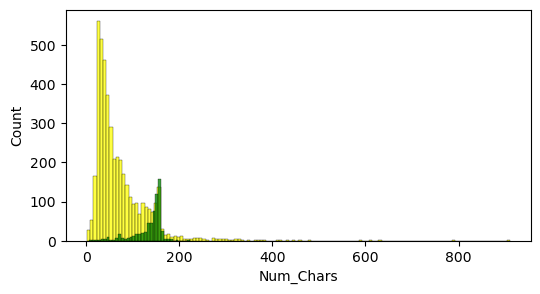

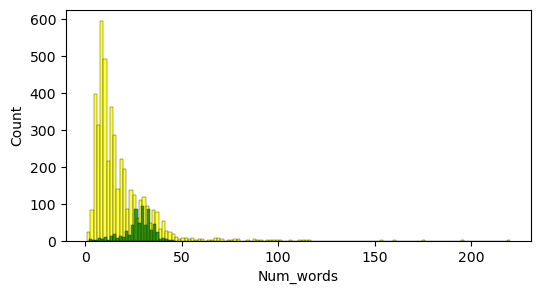

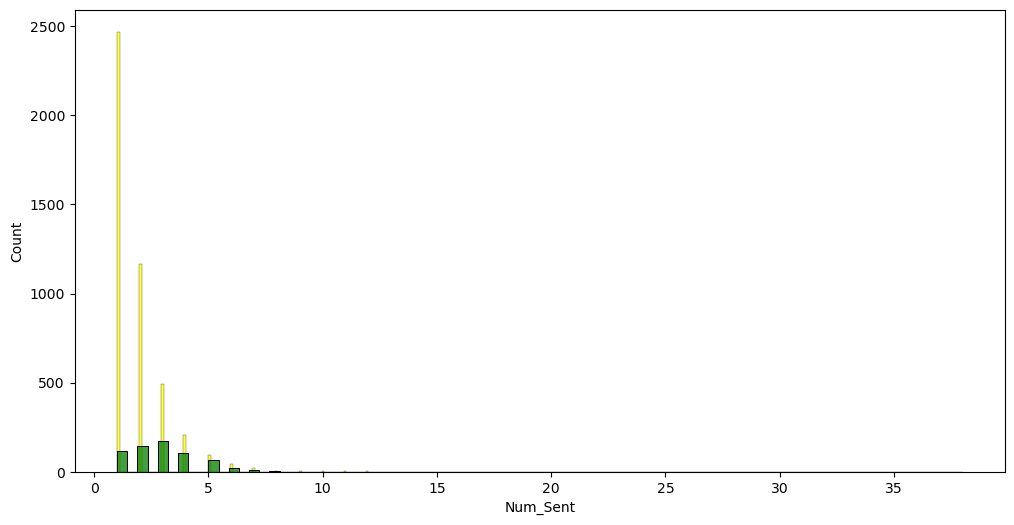

In [50]:
# Visualization of the length of messages
plt.figure(figsize=(6, 3))
sns.histplot(data[data['Category'] == 0]['Num_Chars'], color='yellow')
sns.histplot(data[data['Category'] == 1]['Num_Chars'], color='green')
plt.show()

plt.figure(figsize=(6, 3))
sns.histplot(data[data['Category'] == 0]['Num_words'], color='yellow')
sns.histplot(data[data['Category'] == 1]['Num_words'], color='green')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['Category'] == 0]['Num_Sent'], color='yellow')
sns.histplot(data[data['Category'] == 1]['Num_Sent'], color='green')
plt.show()

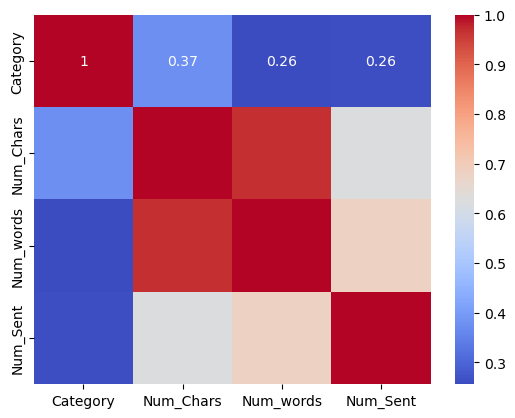

In [51]:
# Creating a heatmap for the pairwise correlation
matrix = data[['Category', 'Num_Chars', 'Num_words', 'Num_Sent']].corr()
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.show()

In [53]:
# Removing stop words and punctuations
stopwords_set = set(stopwords.words('english'))
ps = PorterStemmer()

def message_transform(message):
    message = message.lower()
    message = nltk.word_tokenize(message)
    message = [word for word in message if word.isalnum()]
    message = [word for word in message if word not in stopwords_set]
    message = [ps.stem(word) for word in message]
    return " ".join(message)

data['TransformedMessage'] = data['Message'].apply(message_transform)

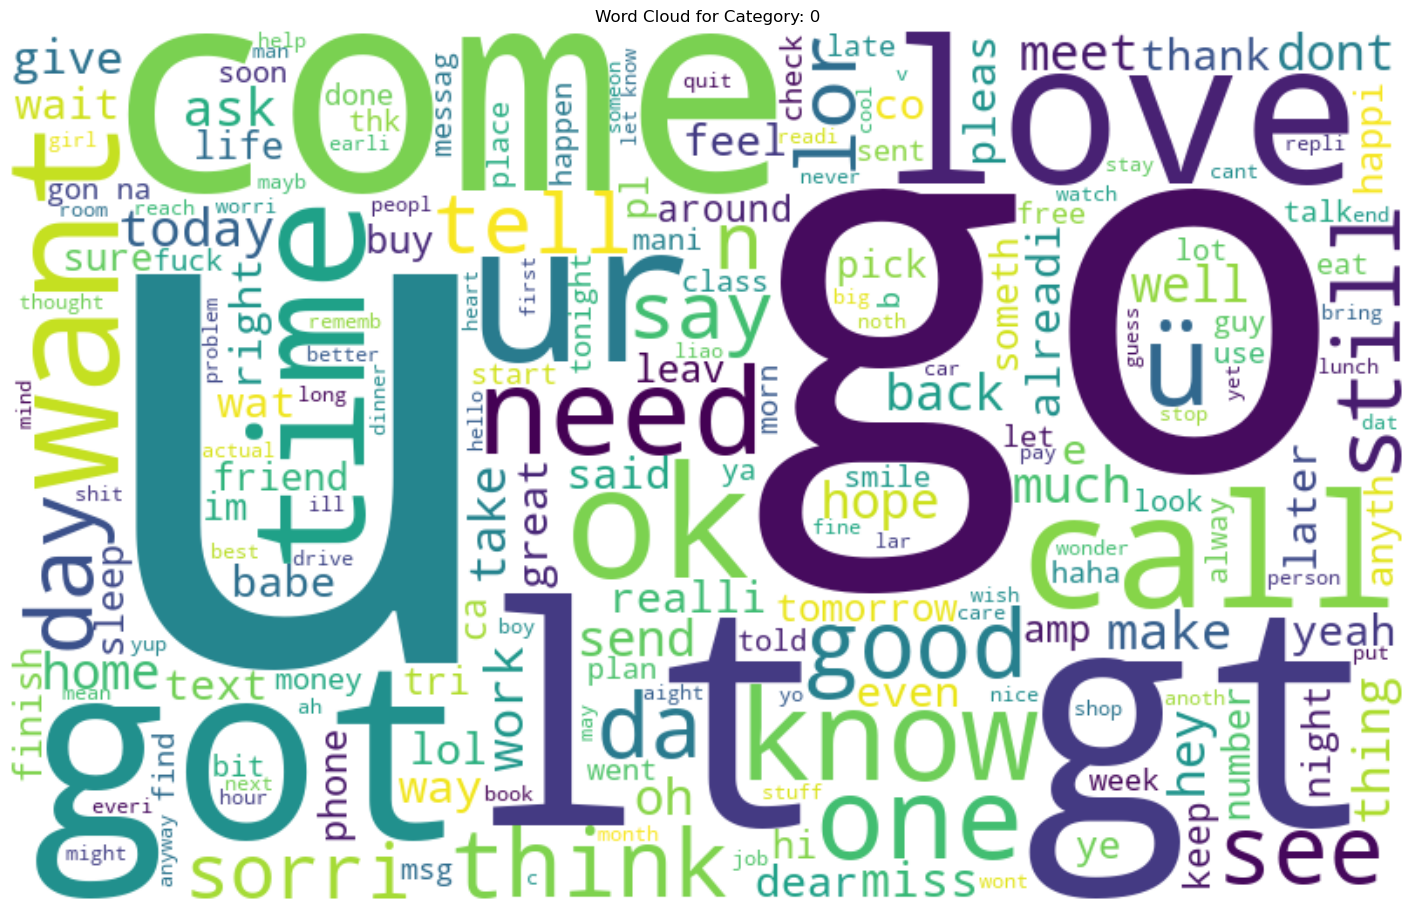

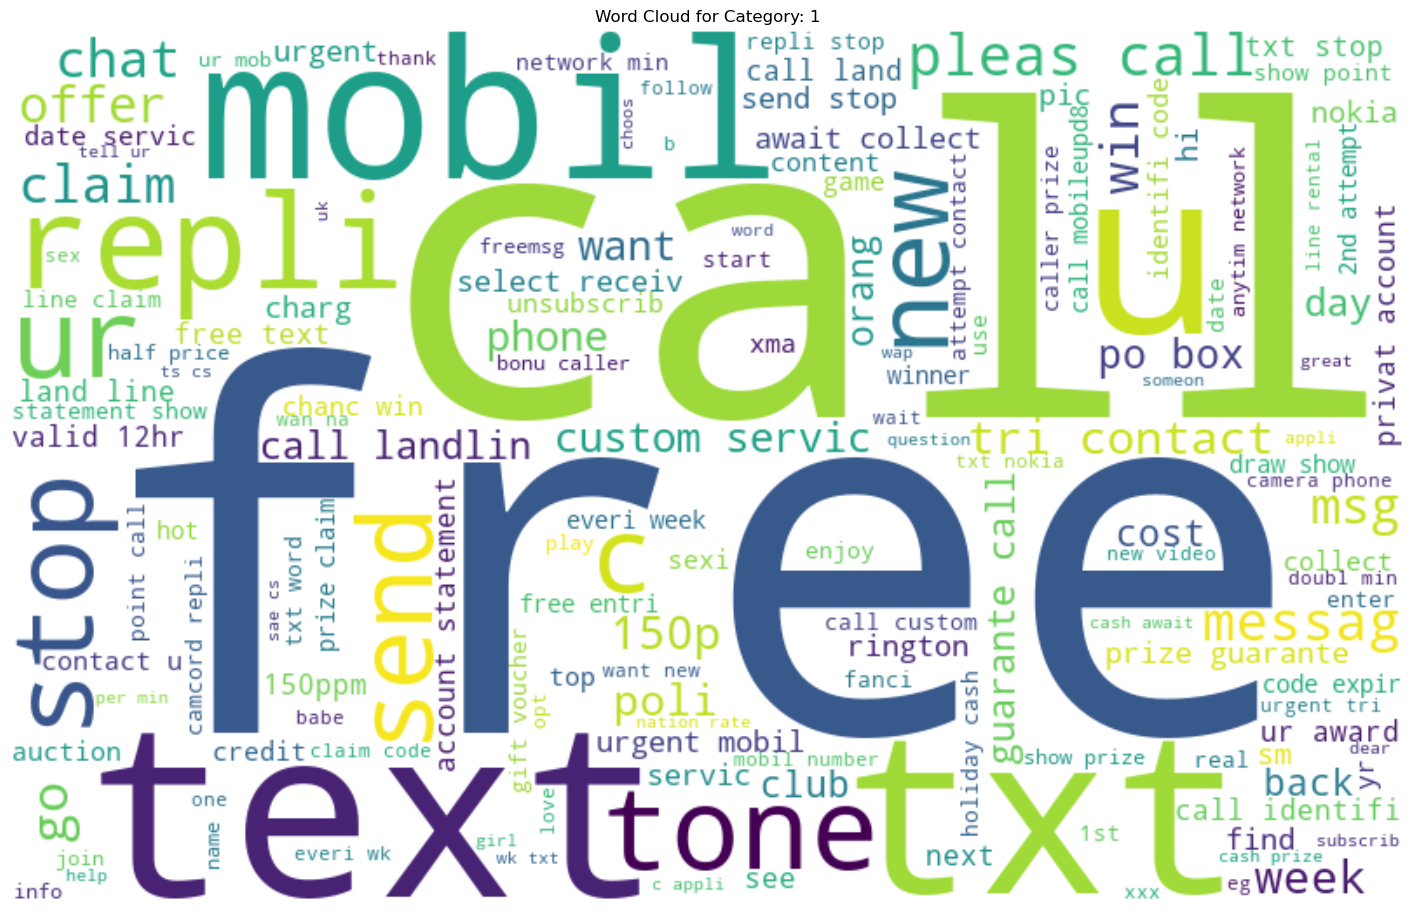

In [54]:
# Word cloud visualization
for category in data['Category'].unique():
    filtered_df = data[data['Category'] == category]
    text = ' '.join(filtered_df['TransformedMessage'])
    wordcloud = WordCloud(width=800, height=500, min_font_size=10, background_color='white').generate(text)
    plt.figure(figsize=(18, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

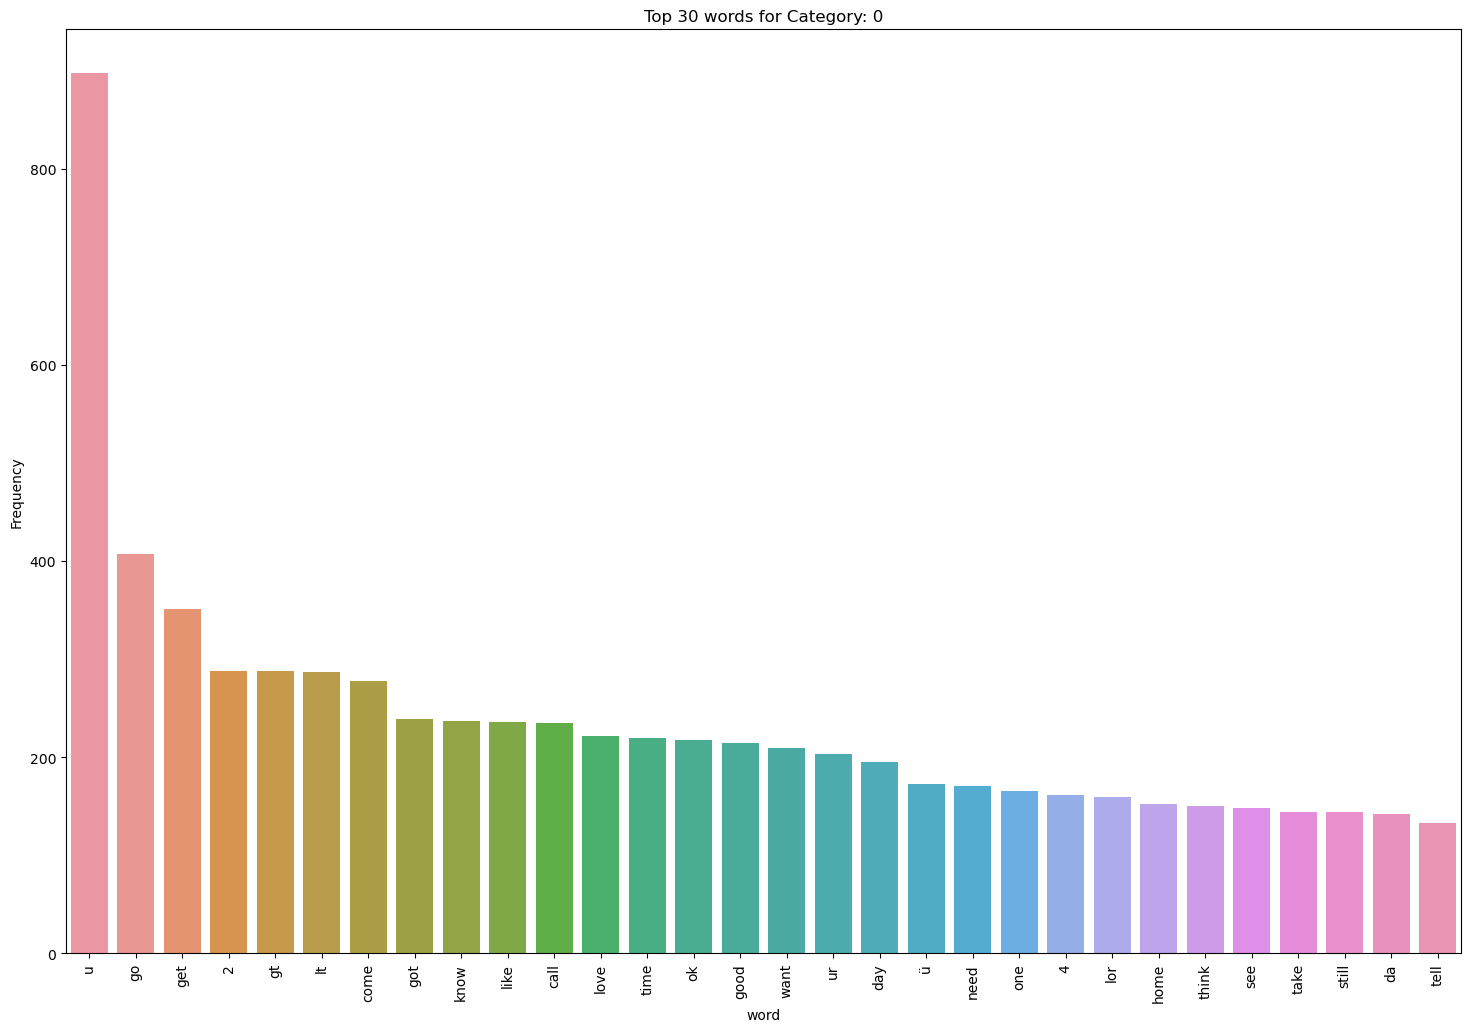

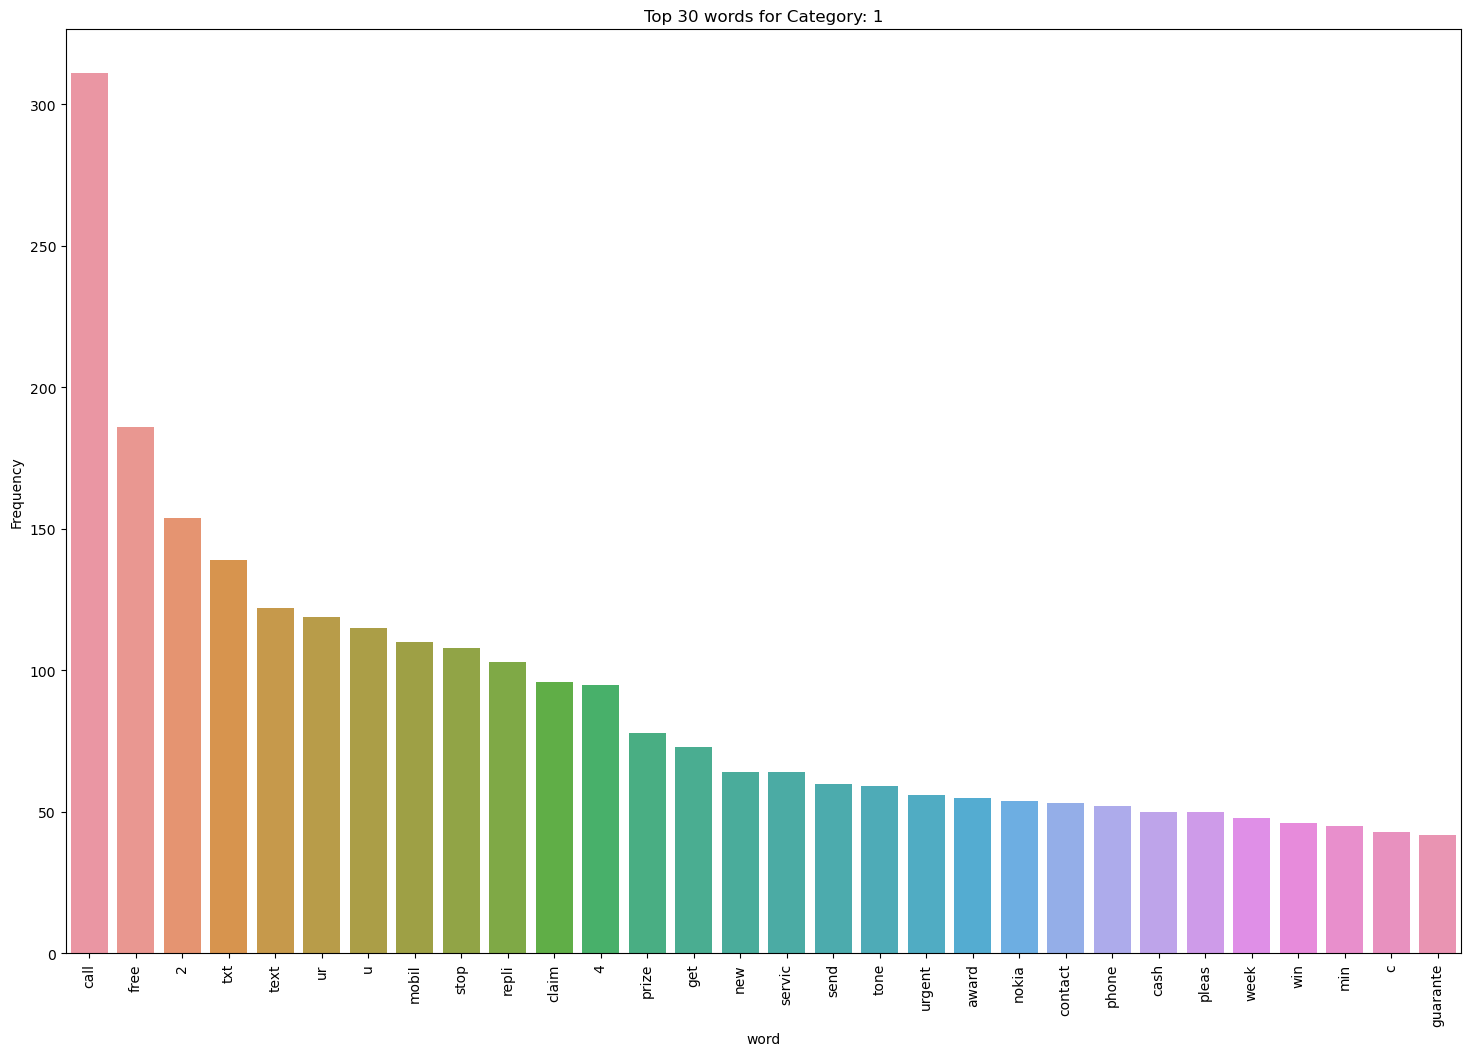

In [55]:
# Top 30 words for each category
for category in data['Category'].unique():
    filtered_df = data[data['Category'] == category]
    words = ' '.join(filtered_df['TransformedMessage']).split()
    most_common_words = Counter(words).most_common(30)
    common_words_df = pd.DataFrame(most_common_words, columns=['word', 'Frequency'])
    plt.figure(figsize=(18, 12))
    plt.title(f'Top 30 words for Category: {category}')
    sns.barplot(x='word', y='Frequency', data=common_words_df)
    plt.xticks(rotation='vertical')
    plt.show()


In [56]:
# Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['TransformedMessage']).toarray()
y = data['Category'].values


In [57]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [58]:
# Define classifiers
clfs = {
    'Logistic Regression': LogisticRegression(),
    'MultinomialNB': MultinomialNB(),
    'GaussianNB': GaussianNB(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN': KNeighborsClassifier(),
}


In [64]:
# Lists to hold scores
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

In [65]:
# Train and evaluate classifiers
for name, classifier in clfs.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    confusion_matrices.append(cm)
    
    print(f'Accuracy score of {name} is: {accuracy}')
    print(f'Confusion Matrix of {name} is:\n{cm}')
    print(f'Precision score of {name} is: {precision}')
    print(f'Recall score of {name} is: {recall}')
    print(f'F1 score of {name} is: {f1}\n')


Accuracy score of Logistic Regression is: 0.9602713178294574
Confusion Matrix of Logistic Regression is:
[[902   3]
 [ 38  89]]
Precision score of Logistic Regression is: 0.967391304347826
Recall score of Logistic Regression is: 0.7007874015748031
F1 score of Logistic Regression is: 0.8127853881278538

Accuracy score of MultinomialNB is: 0.9709302325581395
Confusion Matrix of MultinomialNB is:
[[905   0]
 [ 30  97]]
Precision score of MultinomialNB is: 1.0
Recall score of MultinomialNB is: 0.7637795275590551
F1 score of MultinomialNB is: 0.8660714285714286

Accuracy score of GaussianNB is: 0.8672480620155039
Confusion Matrix of GaussianNB is:
[[785 120]
 [ 17 110]]
Precision score of GaussianNB is: 0.4782608695652174
Recall score of GaussianNB is: 0.8661417322834646
F1 score of GaussianNB is: 0.6162464985994398

Accuracy score of SVM is: 0.9738372093023255
Confusion Matrix of SVM is:
[[905   0]
 [ 27 100]]
Precision score of SVM is: 1.0
Recall score of SVM is: 0.7874015748031497
F1 sco

In [61]:
# Creating and sorting the DataFrame
temp_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy_max_ft_3000': accuracy_scores,
    'Precision_max_ft_3000': precision_scores,
    'Recall_max_ft_3000': recall_scores,
    'F1_max_ft_3000': f1_scores
}).sort_values('Precision_max_ft_3000', ascending=False)

print(temp_df)

             Algorithm  Accuracy_max_ft_3000  Precision_max_ft_3000
1        MultinomialNB              0.970930               1.000000
3                  SVM              0.973837               1.000000
5        Random Forest              0.970930               1.000000
8                  KNN              0.912791               1.000000
6    Gradient Boosting              0.961240               0.978022
0  Logistic Regression              0.960271               0.967391
7             AdaBoost              0.964147               0.924528
4        Decision Tree              0.946705               0.810345
2           GaussianNB              0.867248               0.478261


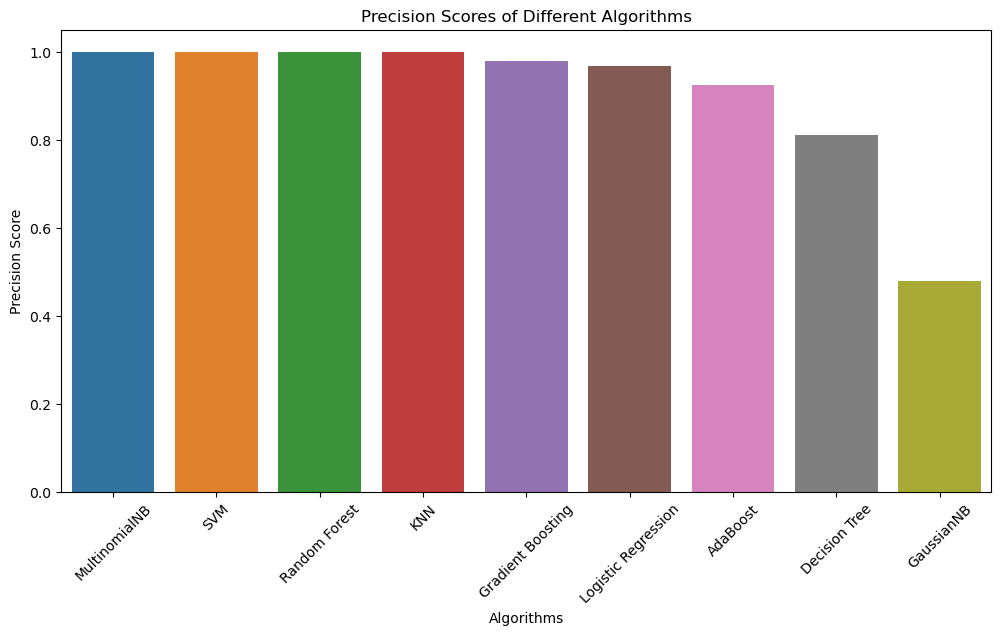

In [62]:
# Plotting the bar plot for precision scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Algorithm', y='Precision_max_ft_3000', data=temp_df)
plt.xlabel('Algorithms')
plt.ylabel('Precision Score')
plt.title('Precision Scores of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Example of hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest: ", grid_search.best_params_)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Importing necessary libraries
from numpy import mean, std, argmax
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import load_img, img_to_array


In [9]:
# Load train and test dataset
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [10]:
# Scale pixels
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

In [12]:
# Define CNN model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
# Evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(dataX):
        model = define_model()
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)
    return scores, histories


In [14]:
# Plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.show()

In [15]:
# Summarize model performance
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    plt.boxplot(scores)
    plt.show()

In [16]:
# Run the test harness for evaluating a model
def run_test_harness():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    scores, histories = evaluate_model(trainX, trainY)
    summarize_diagnostics(histories)
    summarize_performance(scores)
    model = define_model()
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    model.save('final_model.h5')


In [ ]:
# entry point, run the test harness
run_test_harness()

> 98.950
> 98.850
> 98.900
> 99.083


In [ ]:
# Evaluate the saved model on the test dataset
def evaluate_saved_model():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    model = load_model('final_model.h5')
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))


In [ ]:
# Evaluate the saved model
evaluate_saved_model()


In [ ]:
# Make a prediction for a new image
def load_image(filename):
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype('float32')
    img = img / 255.0
    return img

In [ ]:
def run_example():
    img = load_image('sample_image.png')
    model = load_model('final_model.h5')
    predict_value = model.predict(img)
    digit = argmax(predict_value)
    print(digit)

# Run the example
run_example()
import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from wordcloud import WordCloud
from collections import Counter

#Loading data
dataPath="C:/Users/USER/Desktop/ML Materials/CognoRise Internship/TAsk One_Spam/Resources/spam.csv"
data= pd.read_csv(dataPath)

data.head()

# Data cleaning
data.info()

# Encoding the Category
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

# Checking for null values and duplicates
data.isnull().sum()
data.drop_duplicates(inplace=True)

# Data Visualization
plt.pie(data['Category'].value_counts(), labels=['Not Spam', 'Spam'], autopct='%0.2f')
plt.title('Distribution of Spam vs. Ham')
plt.show()

# Counting characters, words, and sentences
data['Num_Chars'] = data['Message'].apply(len)
data['Num_words'] = data['Message'].apply(lambda x: len(word_tokenize(x)))
data['Num_Sent'] = data['Message'].apply(lambda x: len(sent_tokenize(x)))

# Descriptive statistics for not spam and spam messages
print(data[data['Category'] == 0][['Num_Chars', 'Num_words', 'Num_Sent']].describe())
print(data[data['Category'] == 1][['Num_Chars', 'Num_words', 'Num_Sent']].describe())

# Visualization of the length of messages
plt.figure(figsize=(6, 3))
sns.histplot(data[data['Category'] == 0]['Num_Chars'], color='yellow')
sns.histplot(data[data['Category'] == 1]['Num_Chars'], color='green')
plt.show()

plt.figure(figsize=(6, 3))
sns.histplot(data[data['Category'] == 0]['Num_words'], color='yellow')
sns.histplot(data[data['Category'] == 1]['Num_words'], color='green')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['Category'] == 0]['Num_Sent'], color='yellow')
sns.histplot(data[data['Category'] == 1]['Num_Sent'], color='green')
plt.show()

# Creating a heatmap for the pairwise correlation
matrix = data[['Category', 'Num_Chars', 'Num_words', 'Num_Sent']].corr()
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.show()

# Removing stop words and punctuations
stopwords_set = set(stopwords.words('english'))
ps = PorterStemmer()

def message_transform(message):
    message = message.lower()
    message = nltk.word_tokenize(message)
    message = [word for word in message if word.isalnum()]
    message = [word for word in message if word not in stopwords_set]
    message = [ps.stem(word) for word in message]
    return " ".join(message)

data['TransformedMessage'] = data['Message'].apply(message_transform)

# Word cloud visualization
for category in data['Category'].unique():
    filtered_df = data[data['Category'] == category]
    text = ' '.join(filtered_df['TransformedMessage'])
    wordcloud = WordCloud(width=800, height=500, min_font_size=10, background_color='white').generate(text)
    plt.figure(figsize=(18, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

# Top 30 words for each category
for category in data['Category'].unique():
    filtered_df = data[data['Category'] == category]
    words = ' '.join(filtered_df['TransformedMessage']).split()
    most_common_words = Counter(words).most_common(30)
    common_words_df = pd.DataFrame(most_common_words, columns=['word', 'Frequency'])
    plt.figure(figsize=(18, 12))
    plt.title(f'Top 30 words for Category: {category}')
    sns.barplot(x='word', y='Frequency', data=common_words_df)
    plt.xticks(rotation='vertical')
    plt.show()


# Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['TransformedMessage']).toarray()
y = data['Category'].values


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Define classifiers
clfs = {
    'Logistic Regression': LogisticRegression(),
    'MultinomialNB': MultinomialNB(),
    'GaussianNB': GaussianNB(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN': KNeighborsClassifier(),
}


# Lists to hold scores
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

# Train and evaluate classifiers
for name, classifier in clfs.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    confusion_matrices.append(cm)
    
    print(f'Accuracy score of {name} is: {accuracy}')
    print(f'Confusion Matrix of {name} is:\n{cm}')
    print(f'Precision score of {name} is: {precision}')
    print(f'Recall score of {name} is: {recall}')
    print(f'F1 score of {name} is: {f1}\n')


# Creating and sorting the DataFrame
temp_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy_max_ft_3000': accuracy_scores,
    'Precision_max_ft_3000': precision_scores,
    'Recall_max_ft_3000': recall_scores,
    'F1_max_ft_3000': f1_scores
}).sort_values('Precision_max_ft_3000', ascending=False)

print(temp_df)

# Plotting the bar plot for precision scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Algorithm', y='Precision_max_ft_3000', data=temp_df)
plt.xlabel('Algorithms')
plt.ylabel('Precision Score')
plt.title('Precision Scores of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

# Example of hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest: ", grid_search.best_params_)

